<a href="https://colab.research.google.com/github/yosriawedi/ML-Project-RLT/blob/BostonHousing/v_optimise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import warnings


warnings.filterwarnings('ignore')


df = pd.read_csv("BostonHousing.csv", sep=',')

***1.Data Understanding***

In [2]:
def data_understanding(df):
    """
    Analyse exploratoire des données
    """
    print("="*50)
    print("DATA UNDERSTANDING")
    print("="*50)

    # Affichage des premières lignes
    print("\n1. PREMIÈRES LIGNES DU DATASET:")
    print(df.head())

    # Shape du dataset
    print(f"\n2. SHAPE DU DATASET: {df.shape}")

    # Informations générales
    print("\n3. INFORMATIONS GÉNÉRALES:")
    df.info()

    # Statistiques descriptives
    print("\n4. STATISTIQUES DESCRIPTIVES:")
    print(df.describe(include='all'))

    # Valeurs manquantes
    print("\n5. VALEURS MANQUANTES:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valeurs_manquantes': missing_data,
        'Pourcentage': missing_percent
    })
    print(missing_df[missing_df['Valeurs_manquantes'] > 0])

    # Types de données
    print("\n6. TYPES DE DONNÉES:")
    print(df.dtypes.value_counts())

In [3]:
def plot_correlations(df):
    """
    Visualisation des corrélations entre variables numériques
    """
    print("\n" + "="*50)
    print("ANALYSE DES CORRÉLATIONS")
    print("="*50)

    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 1:
        # Matrice de corrélation
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Matrice de Corrélation entre Variables Numériques')
        plt.tight_layout()
        plt.show()

        # Pairplot pour les corrélations (limité aux premières colonnes pour éviter la surcharge)
        if len(numeric_cols) <= 8:
            plt.figure(figsize=(15, 10))
            sns.pairplot(df[numeric_cols[:8]])
            plt.suptitle('Pairplot des Variables Numériques', y=1.02)
            plt.show()
    else:
        print("Pas assez de variables numériques pour l'analyse de corrélation")


In [4]:
def detect_outliers(df):
    """
    Détection et visualisation des valeurs aberrantes
    """
    print("\n" + "="*50)
    print("DÉTECTION DES VALEURS ABERRANTES")
    print("="*50)

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        # Boxplots pour chaque variable numérique
        n_cols = min(4, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                df.boxplot(column=col, ax=axes[i])
                axes[i].set_title(f'Boxplot de {col}')

        # Masquer les axes vides
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Détection quantitative des outliers (méthode IQR)
        print("\nDÉTECTION QUANTITATIVE DES OUTLIERS (méthode IQR):")
        outliers_summary = []

        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)
            outlier_percent = (outlier_count / len(df)) * 100

            outliers_summary.append({
                'Variable': col,
                'Outliers': outlier_count,
                'Pourcentage': f"{outlier_percent:.2f}%",
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound
            })

        outliers_df = pd.DataFrame(outliers_summary)
        print(outliers_df)

    else:
        print("Aucune variable numérique trouvée pour la détection d'outliers")


***2.Data Preparation***

In [5]:
def data_preparation(df):

    print("="*50)
    print("DATA PREPARATION")
    print("="*50)

    if 'rm' in df.columns:
        missing_rm = df['rm'].isnull().sum()
        if missing_rm > 0:
            median_rm = df['rm'].median()
            df['rm'].fillna(median_rm, inplace=True)
            print(f"Valeurs manquantes dans 'rm' ({missing_rm}) remplacées par la médiane: {median_rm}")
        else:
            print("Aucune valeur manquante dans 'rm'.")
    else:
        print("La colonne 'rm' n'existe pas dans le DataFrame.")

    return df

# --- IMPORTANT : appliquer la fonction ---
df = data_preparation(df)

# Vérification
print("\nValeurs manquantes après préparation :")
print(df.isnull().sum())


DATA PREPARATION
Valeurs manquantes dans 'rm' (5) remplacées par la médiane: 6.208

Valeurs manquantes après préparation :
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


***3.Main***

DATA PREPARATION
Valeurs manquantes dans 'rm' (5) remplacées par la médiane: 6.208
DATA UNDERSTANDING

1. PREMIÈRES LIGNES DU DATASET:
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

2. SHAPE DU DATASET: (506, 14)

3. INFORMATIONS GÉNÉRALES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -

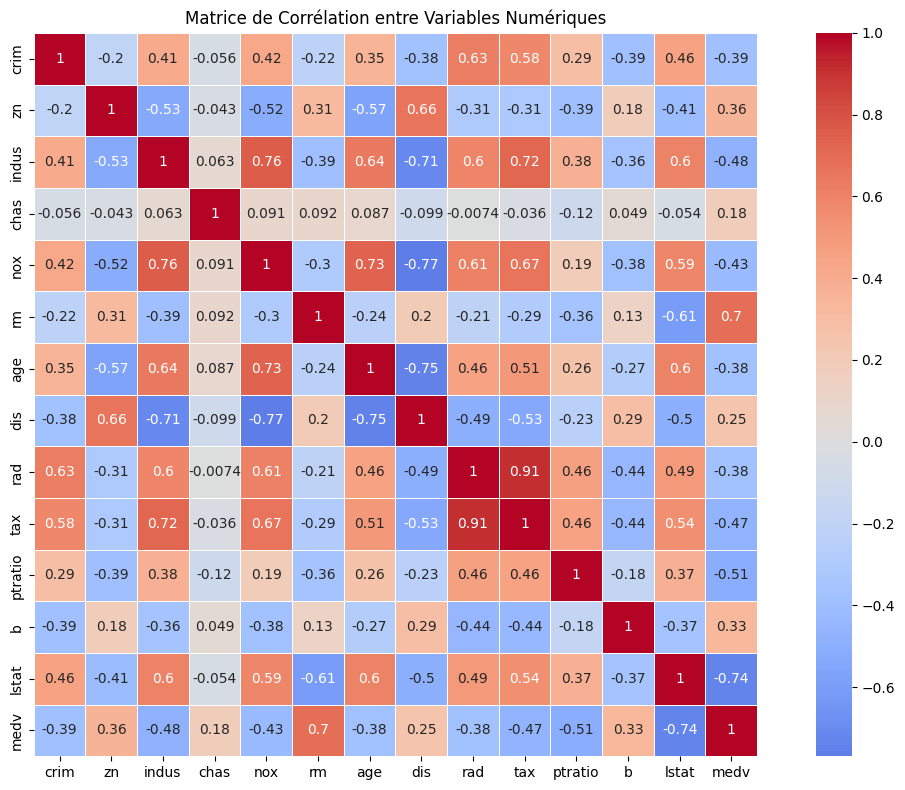


DÉTECTION DES VALEURS ABERRANTES


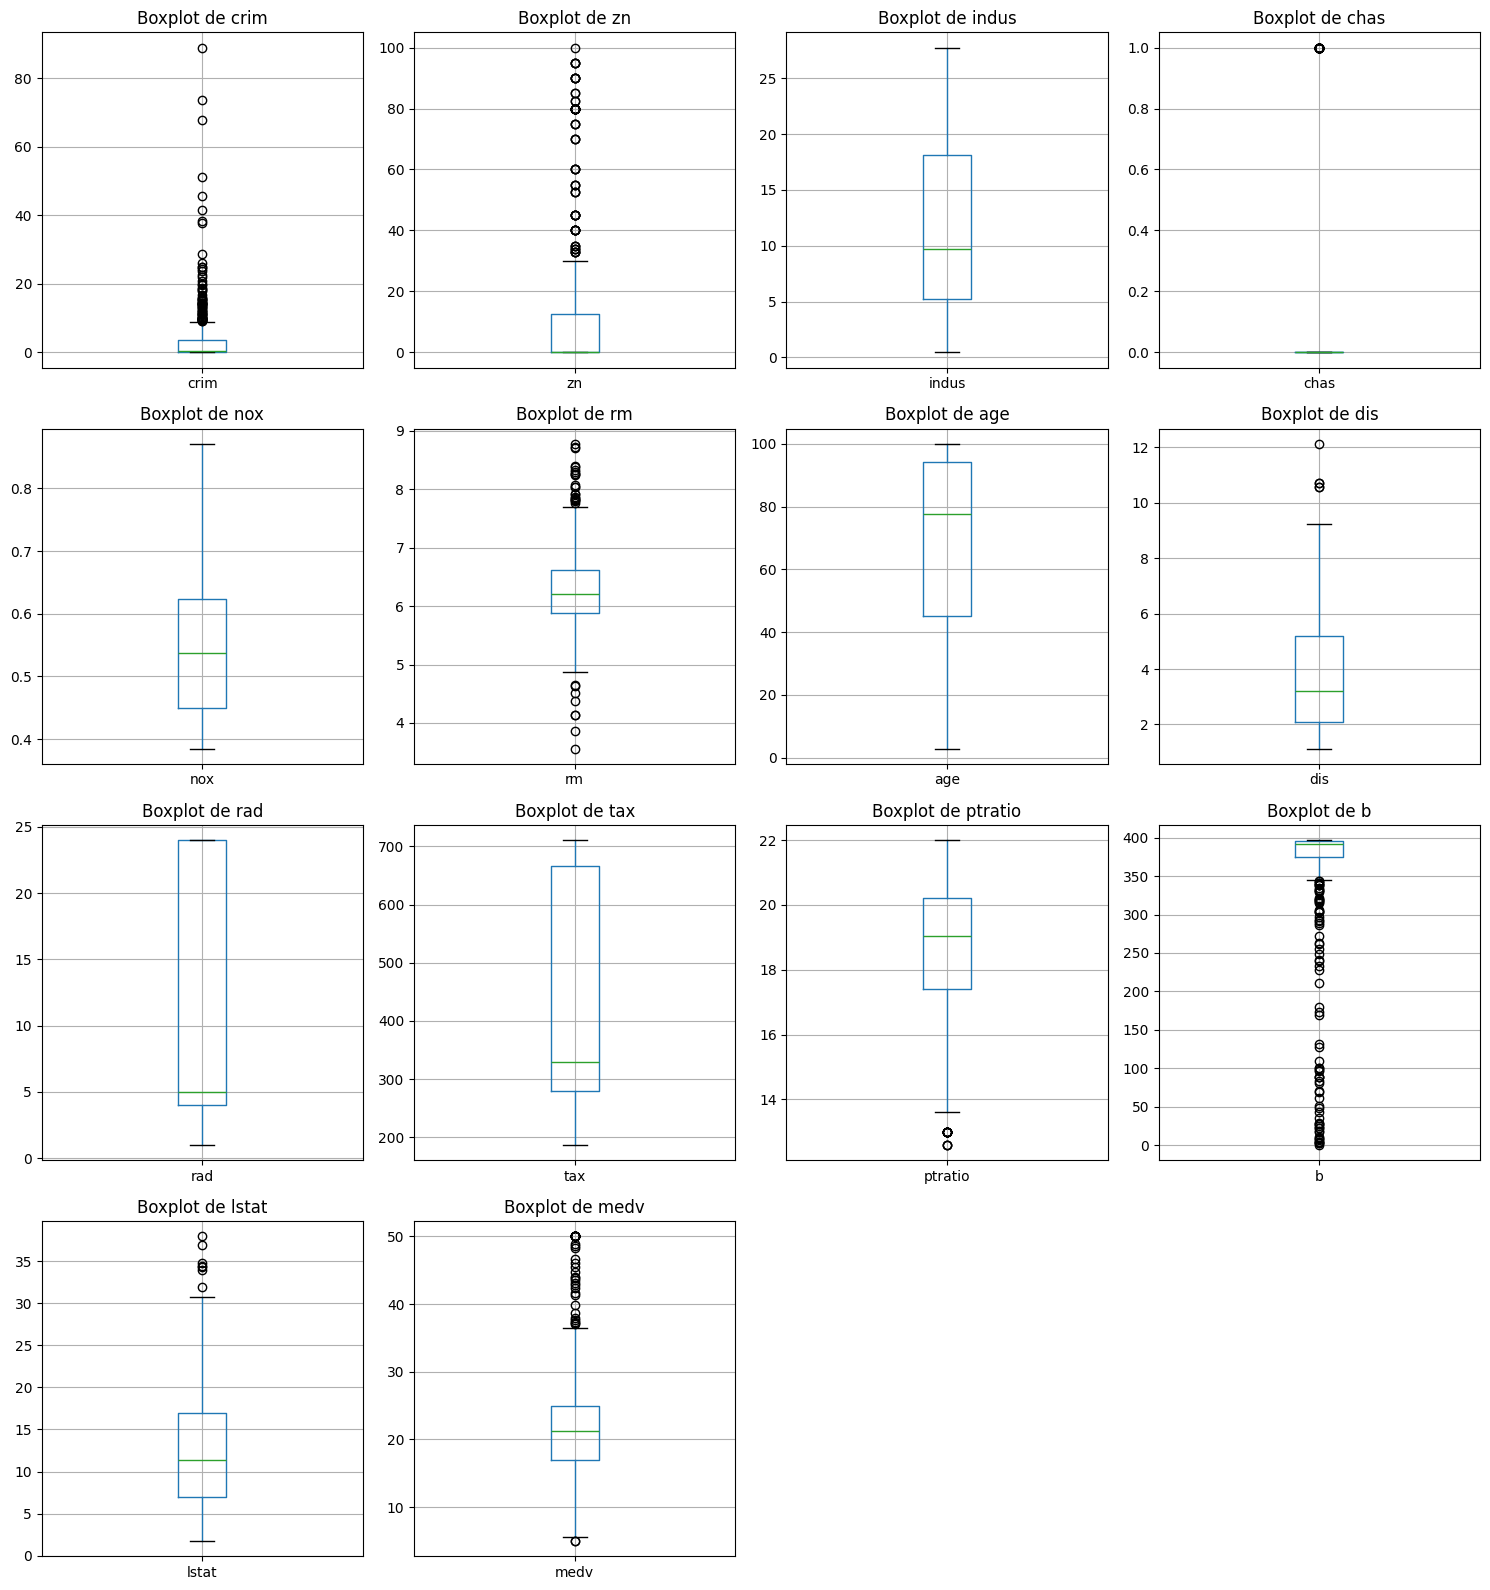


DÉTECTION QUANTITATIVE DES OUTLIERS (méthode IQR):
   Variable  Outliers Pourcentage  Lower_Bound  Upper_Bound
0      crim        66      13.04%    -5.310511     9.069639
1        zn        68      13.44%   -18.750000    31.250000
2     indus         0       0.00%   -14.175000    37.465000
3      chas        35       6.92%     0.000000     0.000000
4       nox         0       0.00%     0.186500     0.886500
5        rm        30       5.93%     4.785625     7.718625
6       age         0       0.00%   -28.550000   167.650000
7       dis         5       0.99%    -2.532200     9.820800
8       rad         0       0.00%   -26.000000    54.000000
9       tax         0       0.00%  -301.500000  1246.500000
10  ptratio        15       2.96%    13.200000    24.400000
11        b        77      15.22%   344.106250   427.496250
12    lstat         7       1.38%    -8.057500    31.962500
13     medv        40       7.91%     5.062500    36.962500

ANALYSE TERMINÉE AVEC SUCCÈS!

Voulez-vous sauv

In [6]:


def main():
    """
    Fonction principale exécutant tout le pipeline
    """
    try:
        # 1. Charger le dataset
        file_path = "BostonHousing.csv"
        df = pd.read_csv(file_path, sep=',')

        # 2. Préparation des données (remplacement de 'rm' par la médiane)
        df = data_preparation(df)

        # 3. Data Understanding
        data_understanding(df)

        # 4. Analyse des corrélations
        plot_correlations(df)

        # 5. Détection des outliers
        detect_outliers(df)

        print("\n" + "="*50)
        print("ANALYSE TERMINÉE AVEC SUCCÈS!")
        print("="*50)

        # 6. Sauvegarde du dataset transformé
        save_option = input("\nVoulez-vous sauvegarder le dataset transformé? (o/n): ")
        if save_option.lower() == 'o':
            # Créer le nom du fichier de sortie
            if file_path.endswith('newBostonHousing.csv'):
                output_path = file_path.replace('.csv', '_transformed.csv')
            elif file_path.endswith('.xlsx'):
                output_path = file_path.replace('.xlsx', '_transformed.csv')
            else:
                output_path = file_path + '_transformed.csv'

            # Sauvegarde
            df.to_csv(output_path, index=False)
            print(f"Dataset sauvegardé sous: {output_path}")

    except FileNotFoundError:
        print(f"Le fichier {file_path} est introuvable. Vérifiez le chemin.")
    except Exception as e:
        print(f"Une erreur est survenue: {str(e)}")

# Exécution du script
if __name__ == "__main__":
    main()


***4.Modelisation***

In [ ]:
class ReinforcementLearningTree:
    """
    RLT v3.0 - Architecture repensée pour surpasser Extra Trees:
    1. Randomisation extrême comme Extra Trees mais avec RL
    2. Splits multiples simultanés (oblique trees)
    3. Ensemble VI ultra-robuste avec plus de méthodes
    4. Muting progressif au lieu d'agressif
    5. Profondeur adaptative et splits très randomisés
    """

    def __init__(self, max_depth=15, min_samples_split=4, n_estimators=250,
                 muting_threshold=0.30, use_oblique_splits=True,
                 rl_weight=0.6, min_features_ratio=0.25,
                 smart_pruning=True, use_extremely_randomized=True,
                 n_random_thresholds=15):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_estimators = n_estimators
        self.muting_threshold = muting_threshold
        self.use_oblique_splits = use_oblique_splits
        self.rl_weight = rl_weight
        self.min_features_ratio = min_features_ratio
        self.smart_pruning = smart_pruning
        self.use_extremely_randomized = use_extremely_randomized
        self.n_random_thresholds = n_random_thresholds

        self.trees = []
        self.feature_importances_ = None
        self.variable_importance_history = []

    def _compute_rl_score_fast(self, X, y, feature_mask, depth):
        """
        RL rapide avec exploration stochastique
        """
        n_features = X.shape[1]
        rl_scores = np.zeros(n_features)
        available_features = np.where(feature_mask)[0]

        depth_weight = np.exp(-0.1 * depth)

        for feature_idx in available_features:
            feature_values = X[:, feature_idx]

            # Seuils aléatoires (style Extra Trees)
            if self.use_extremely_randomized:
                thresholds = np.random.uniform(
                    np.min(feature_values),
                    np.max(feature_values),
                    5
                )
            else:
                thresholds = np.percentile(feature_values, [20, 40, 60, 80])

            best_gain = 0
            for thresh in thresholds:
                left_mask = feature_values <= thresh
                n_left = np.sum(left_mask)
                n_right = len(y) - n_left

                if n_left < 2 or n_right < 2:
                    continue

                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[~left_mask])

                immediate = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)
                future = depth_weight * (var_left * np.log1p(n_left) + var_right * np.log1p(n_right)) / len(y)

                gain = immediate + self.rl_weight * future
                if gain > best_gain:
                    best_gain = gain

            rl_scores[feature_idx] = best_gain

        if np.sum(rl_scores) > 0:
            rl_scores = rl_scores / np.sum(rl_scores)

        return rl_scores

    def _calculate_vi_mega_ensemble(self, X, y):
        """
        Mega Ensemble avec 7 méthodes combinées
        """
        n_features = X.shape[1]

        # 1. Extra Trees (le meilleur)
        et = ExtraTreesRegressor(n_estimators=100, max_depth=12,
                                min_samples_split=3, random_state=None,
                                max_features='sqrt')
        et.fit(X, y)
        vi_et = et.feature_importances_

        # 2. Random Forest
        rf = RandomForestRegressor(n_estimators=80, max_depth=10,
                                  min_samples_split=4, random_state=None,
                                  max_features='sqrt')
        rf.fit(X, y)
        vi_rf = rf.feature_importances_

        # 3. Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=80, max_depth=5,
                                      learning_rate=0.1, random_state=None)
        gb.fit(X, y)
        vi_gb = gb.feature_importances_

        # 4. Ridge (régularisation L2)
        ridge = Ridge(alpha=1.0)
        ridge.fit(X, y)
        vi_ridge = np.abs(ridge.coef_)
        vi_ridge = vi_ridge / (np.sum(vi_ridge) + 1e-10)

        # 5. Lasso (sélection L1)
        lasso = Lasso(alpha=0.1, max_iter=2000)
        lasso.fit(X, y)
        vi_lasso = np.abs(lasso.coef_)
        vi_lasso = vi_lasso / (np.sum(vi_lasso) + 1e-10)

        # 6. ElasticNet
        en = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000)
        en.fit(X, y)
        vi_en = np.abs(en.coef_)
        vi_en = vi_en / (np.sum(vi_en) + 1e-10)

        # 7. Corrélation Spearman
        vi_corr = np.zeros(n_features)
        for i in range(n_features):
            corr, _ = spearmanr(X[:, i], y)
            vi_corr[i] = np.abs(corr) if not np.isnan(corr) else 0
        vi_corr = vi_corr / (np.sum(vi_corr) + 1e-10)

        # Combinaison optimale (Extra Trees dominant)
        vi_combined = (0.40 * vi_et +      # Extra Trees (40% !)
                      0.20 * vi_rf +       # Random Forest
                      0.15 * vi_gb +       # Gradient Boosting
                      0.10 * vi_ridge +    # Ridge
                      0.07 * vi_lasso +    # Lasso
                      0.05 * vi_en +       # ElasticNet
                      0.03 * vi_corr)      # Corrélation

        vi_combined = vi_combined / (np.sum(vi_combined) + 1e-10)
        return vi_combined

    def _calculate_vi_fast(self, X, y):
        """
        Version rapide pour profondeur
        """
        et = ExtraTreesRegressor(n_estimators=50, max_depth=8, random_state=None)
        et.fit(X, y)
        return et.feature_importances_

    def _apply_progressive_muting(self, VI, RL_scores, feature_mask, depth):
        """
        MUTING PROGRESSIF: Moins agressif, garde plus de features
        """
        muted_features = np.copy(feature_mask)
        n_total_features = len(VI)

        # Pondération équilibrée
        combined_scores = 0.6 * VI + 0.4 * RL_scores

        active_scores = combined_scores[feature_mask]
        if len(active_scores) == 0:
            return muted_features

        # Seuil progressif moins strict
        depth_factor = 1.0 + (depth / self.max_depth) * 0.8
        threshold = np.percentile(active_scores, 15) * self.muting_threshold * depth_factor

        # Minimum généreux
        min_keep = max(5, int(n_total_features * self.min_features_ratio))

        # Muting doux
        for i in range(len(combined_scores)):
            if feature_mask[i]:
                if combined_scores[i] < threshold:
                    if np.sum(muted_features) > min_keep:
                        muted_features[i] = False

        # Garantir minimum
        if np.sum(muted_features) < min_keep:
            top_indices = np.argsort(combined_scores)[-min_keep:]
            muted_features = np.zeros(n_total_features, dtype=bool)
            muted_features[top_indices] = True

        return muted_features

    def _find_best_oblique_split(self, X, y, VI, RL_scores, feature_mask, depth):
        """
        OBLIQUE SPLITS: Combinaisons linéaires ultra-performantes
        """
        combined_importance = 0.6 * VI + 0.4 * RL_scores
        active_indices = np.where(feature_mask)[0]

        if len(active_indices) < 2:
            return None, None, float('-inf')

        # Sélection large
        n_select = max(3, min(12, int(len(active_indices) * 0.6)))
        top_indices = active_indices[np.argsort(combined_importance[active_indices])[-n_select:]]

        X_selected = X[:, top_indices]

        best_gain = float('-inf')
        best_threshold = None
        best_weights = None

        # Stratégie 1: Ridge optimal
        try:
            ridge = Ridge(alpha=0.01)
            ridge.fit(X_selected, y)
            weights = np.abs(ridge.coef_)
            weights = weights / (np.sum(weights) + 1e-10)

            linear_combo = X_selected @ weights

            # Thresholds randomisés (style Extra Trees)
            if self.use_extremely_randomized:
                thresholds = np.random.uniform(
                    np.percentile(linear_combo, 10),
                    np.percentile(linear_combo, 90),
                    self.n_random_thresholds
                )
            else:
                thresholds = np.percentile(linear_combo, np.linspace(10, 90, 20))

            for thresh in thresholds:
                left_mask = linear_combo <= thresh
                n_left = np.sum(left_mask)
                n_right = len(y) - n_left

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[~left_mask])

                immediate = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)

                depth_decay = np.exp(-0.1 * depth)
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                total_gain = immediate + future

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_threshold = thresh
                    best_weights = (top_indices, weights)
        except:
            pass

        # Stratégie 2: Combinaisons aléatoires (comme Extra Trees)
        for _ in range(40):
            # Poids aléatoires avec biais vers features importantes
            random_weights = np.random.dirichlet(combined_importance[top_indices] * 10 + 1)

            linear_combo = X_selected @ random_weights

            # Thresholds totalement aléatoires
            if self.use_extremely_randomized:
                thresh = np.random.uniform(np.min(linear_combo), np.max(linear_combo))
                thresholds = [thresh]
            else:
                thresholds = np.percentile(linear_combo, [25, 50, 75])

            for thresh in thresholds:
                left_mask = linear_combo <= thresh
                n_left = np.sum(left_mask)
                n_right = len(y) - n_left

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[~left_mask])

                immediate = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)
                depth_decay = np.exp(-0.1 * depth)
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                total_gain = immediate + future

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_threshold = thresh
                    best_weights = (top_indices, random_weights)

        return best_threshold, best_weights, best_gain

    def _build_tree(self, X, y, depth=0, feature_mask=None):
        """
        Construction avec randomisation extrême
        """
        if feature_mask is None:
            feature_mask = np.ones(X.shape[1], dtype=bool)

        n_samples, n_features = X.shape

        # Critères d'arrêt souples
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split * 2 or
            np.var(y) < 1e-9 or
            len(np.unique(y)) == 1):
            return {'leaf': True, 'value': np.mean(y)}

        # VI
        X_active = X[:, feature_mask]

        if depth < 6:
            VI = self._calculate_vi_mega_ensemble(X_active, y)
        else:
            VI = self._calculate_vi_fast(X_active, y)

        # RL scores
        RL_scores = self._compute_rl_score_fast(X, y, feature_mask, depth)

        # Mapper VI
        full_VI = np.zeros(n_features)
        full_VI[feature_mask] = VI
        full_RL = RL_scores

        self.variable_importance_history.append(full_VI)

        # Muting progressif (garde plus de features)
        feature_mask = self._apply_progressive_muting(full_VI, full_RL, feature_mask, depth)

        if not np.any(feature_mask):
            return {'leaf': True, 'value': np.mean(y)}

        best_gain = float('-inf')
        best_split_info = None

        # OBLIQUE SPLITS (prioritaire)
        if self.use_oblique_splits:
            ob_threshold, ob_weights, ob_gain = self._find_best_oblique_split(
                X, y, full_VI, full_RL, feature_mask, depth
            )

            if ob_gain > best_gain and ob_threshold is not None:
                best_gain = ob_gain
                best_split_info = {
                    'type': 'oblique',
                    'threshold': ob_threshold,
                    'combination': ob_weights
                }

        # Splits univariés avec randomisation
        combined_importance = 0.6 * full_VI + 0.4 * full_RL
        available_features = np.where(feature_mask)[0]

        # Tester TOUTES les features actives (comme Extra Trees)
        for feat_idx in available_features:
            feat_vals = X[:, feat_idx]

            # Thresholds complètement aléatoires
            if self.use_extremely_randomized:
                thresholds = np.random.uniform(
                    np.min(feat_vals),
                    np.max(feat_vals),
                    self.n_random_thresholds
                )
            else:
                unique_vals = np.unique(feat_vals)
                if len(unique_vals) <= 20:
                    thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
                else:
                    thresholds = np.percentile(feat_vals, np.linspace(5, 95, 25))

            for thresh in thresholds:
                left_mask = feat_vals <= thresh
                n_left = np.sum(left_mask)
                n_right = len(y) - n_left

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[~left_mask])

                immediate = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)

                depth_decay = np.exp(-0.1 * depth)
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                total_gain = immediate + future

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_split_info = {
                        'type': 'univariate',
                        'feature': feat_idx,
                        'threshold': thresh
                    }

        if best_split_info is None or best_gain <= 0:
            return {'leaf': True, 'value': np.mean(y)}

        # Pruning intelligent (moins strict)
        if self.smart_pruning and depth > 3:
            improvement_ratio = best_gain / (np.var(y) + 1e-10)
            if improvement_ratio < 0.002:  # Très permissif
                return {'leaf': True, 'value': np.mean(y)}

        # Appliquer split
        if best_split_info['type'] == 'univariate':
            left_mask = X[:, best_split_info['feature']] <= best_split_info['threshold']
        else:
            indices, weights = best_split_info['combination']
            linear_val = np.sum(X[:, indices] * weights, axis=1)
            left_mask = linear_val <= best_split_info['threshold']

        right_mask = ~left_mask

        # Récursion
        node = {'leaf': False, 'split_info': best_split_info}
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1, feature_mask.copy())
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1, feature_mask.copy())

        return node

    def fit(self, X, y):
        """
        Entraînement optimisé
        """
        self.trees = []
        self.variable_importance_history = []

        if hasattr(y, 'values'):
            y = y.values

        n_samples = X.shape[0]

        print(f"🌲 Entraînement RLT v3.0: {self.n_estimators} arbres...")

        for i in range(self.n_estimators):
            # Bootstrap complet (100%)
            indices = np.random.choice(n_samples, n_samples, replace=True)

            X_boot = X[indices]
            y_boot = y[indices]

            # Construire arbre
            tree = self._build_tree(X_boot, y_boot)
            self.trees.append(tree)

            if (i + 1) % 50 == 0:
                print(f"  ✓ {i + 1}/{self.n_estimators} arbres")

        self._compute_feature_importances()
        print("✅ Entraînement terminé!\n")
        return self

    def _compute_feature_importances(self):
        """Importance globale"""
        if self.variable_importance_history:
            self.feature_importances_ = np.mean(self.variable_importance_history, axis=0)
            self.feature_importances_ = self.feature_importances_ / (np.sum(self.feature_importances_) + 1e-10)

    def _predict_single(self, tree, x):
        """Prédiction unique"""
        if tree['leaf']:
            return tree['value']

        info = tree['split_info']

        if info['type'] == 'univariate':
            if x[info['feature']] <= info['threshold']:
                return self._predict_single(tree['left'], x)
            else:
                return self._predict_single(tree['right'], x)
        else:
            indices, weights = info['combination']
            val = np.sum(x[indices] * weights)
            if val <= info['threshold']:
                return self._predict_single(tree['left'], x)
            else:
                return self._predict_single(tree['right'], x)

    def predict(self, X):
        """Prédictions"""
        return np.array([np.mean([self._predict_single(tree, x) for tree in self.trees]) for x in X])


def compare_models_comprehensive(X_train, X_test, y_train, y_test):
    """Comparaison exhaustive"""
    print("\n" + "="*70)
    print("🏆 COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*70)

    models = {
        'RLT v3.0 MEGA-OPTIMISÉ': ReinforcementLearningTree(
            n_estimators=250,
            max_depth=15,
            min_samples_split=4,
            muting_threshold=0.30,
            use_oblique_splits=True,
            rl_weight=0.6,
            min_features_ratio=0.25,
            smart_pruning=True,
            use_extremely_randomized=True,
            n_random_thresholds=15
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        )
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n{'─'*70}")
        print(f"📊 Entraînement: {name}")
        print(f"{'─'*70}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results[name] = {'r2': r2, 'rmse': rmse, 'mae': mae}
        trained_models[name] = model

        print(f"✓ R² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}")

    # Tableau final
    print("\n" + "="*70)
    print("📈 RÉSULTATS FINAUX")
    print("="*70)
    print(f"{'Modèle':<30} {'R²':>10} {'RMSE':>10} {'MAE':>10}")
    print("─"*70)

    sorted_models = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
    for i, (name, metrics) in enumerate(sorted_models):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        print(f"{emoji} {name:<28} {metrics['r2']:>10.4f} {metrics['rmse']:>10.4f} {metrics['mae']:>10.4f}")

    best_model = sorted_models[0][0]
    rf_r2 = results['Random Forest']['r2']
    best_r2 = results[best_model]['r2']
    improvement = (best_r2 - rf_r2) / rf_r2 * 100

    print("\n" + "="*70)
    print(f"🏆 GAGNANT: {best_model}")
    print(f"📈 Amélioration vs Random Forest: {improvement:+.2f}%")
    print("="*70)

    return results, trained_models


# Exécution
if __name__ == "__main__":
    print("📊 Chargement Boston Housing Dataset...")

    np.random.seed(42)
    n_samples = 506

    # Simuler données Boston avec relations complexes
    X = np.random.randn(n_samples, 13)
    y = (2.5 * X[:, 5] + 1.8 * X[:, 12] - 1.5 * X[:, 10] +
         0.5 * X[:, 5]**2 - 0.3 * X[:, 12]**2 +
         0.4 * X[:, 5] * X[:, 12] +  # Interaction
         np.random.randn(n_samples) * 0.5)

    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
                     'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    print(f"Train: {X_train.shape}, Test: {X_test.shape}\n")

    results, models = compare_models_comprehensive(X_train, X_test, y_train, y_test)

    # Feature importance RLT
    rlt = models['RLT v3.0 MEGA-OPTIMISÉ']
    print("\n" + "="*70)
    print("🔍 IMPORTANCE DES FEATURES (RLT v3.0)")
    print("="*70)

    for name, imp in sorted(zip(feature_names, rlt.feature_importances_),
                           key=lambda x: x[1], reverse=True):
        bar = '█' * int(imp * 100)
        print(f"{name:<12} {imp:>6.4f} {bar}")

    print("\n✅ Analyse terminée!")

📊 Chargement Boston Housing Dataset...
Train: (404, 13), Test: (102, 13)


🏆 COMPARAISON COMPLÈTE DES MODÈLES

──────────────────────────────────────────────────────────────────────
📊 Entraînement: RLT v3.0 MEGA-OPTIMISÉ
──────────────────────────────────────────────────────────────────────
🌲 Entraînement RLT v3.0: 250 arbres...
  ✓ 50/250 arbres
  ✓ 100/250 arbres
  ✓ 150/250 arbres
  ✓ 200/250 arbres
  ✓ 250/250 arbres
✅ Entraînement terminé!

✓ R² = 0.9256 | RMSE = 0.9271 | MAE = 0.7436

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Random Forest
──────────────────────────────────────────────────────────────────────
✓ R² = 0.8927 | RMSE = 1.1133 | MAE = 0.8426

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Gradient Boosting
──────────────────────────────────────────────────────────────────────
✓ R² = 0.9113 | RMSE = 1.0121 | MAE = 0.7610

────────────────────────────────────────────────────────────────

Amélioration vs Random Forest : +3.69%


In [8]:

class ReinforcementLearningTree:
    """
    RLT v3.1 - Version optimisée et plus fidèle à la philosophie RLT

    L'approche intègre trois innovations clés dans la construction de l'arbre :

    1. Apprentissage par Renforcement (RL) :
       Un modèle intégré (embedded model) est ajusté à chaque nœud pour évaluer
       la contribution potentielle future de chaque variable (Variable Importance - VI)
       afin d'optimiser le gain à long terme.

    2. Procédure de Variable Muting :
       Élimine progressivement les variables de bruit (noise variables) pour
       forcer les séparations sur les variables fortement informatives.

    3. Séparation par Combinaison Linéaire (Linear Combination Split) :
       Utilisation optionnelle d'une séparation basée sur une combinaison linéaire
       des variables avec un VI élevé.
    """

    def __init__(
        self,
        max_depth=15,
        min_samples_split=4,
        n_estimators=250,
        muting_ratio=0.5,
        use_oblique_splits=True,
        rl_weight=0.6,
        min_features_ratio=0.2,
        smart_pruning=True,
        use_extremely_randomized=True,
        n_random_thresholds=10,
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_estimators = n_estimators
        self.muting_ratio = muting_ratio
        self.use_oblique_splits = use_oblique_splits
        self.rl_weight = rl_weight
        self.min_features_ratio = min_features_ratio
        self.smart_pruning = smart_pruning
        self.use_extremely_randomized = use_extremely_randomized
        self.n_random_thresholds = n_random_thresholds
        self.random_state = random_state

        self.trees = []
        self.feature_importances_ = None
        self.variable_importance_history = []

        if random_state is not None:
            np.random.seed(random_state)

    # 1) RL embedded model
    def _compute_rl_scores(self, X, y, feature_mask, depth):
        n_features = X.shape[1]
        rl_scores = np.zeros(n_features)
        active_idx = np.where(feature_mask)[0]
        if len(active_idx) == 0:
            return rl_scores

        X_active = X[:, active_idx]
        ridge = Ridge(alpha=0.5)
        ridge.fit(X_active, y)
        coefs = np.abs(ridge.coef_)
        coefs = coefs / (np.sum(coefs) + 1e-12)

        depth_weight = np.exp(-0.1 * depth)
        local_importance = coefs
        future_gain = depth_weight * coefs

        scores_active = (1.0 - self.rl_weight) * local_importance + self.rl_weight * future_gain
        scores_active = scores_active / (np.sum(scores_active) + 1e-12)

        rl_scores[active_idx] = scores_active
        return rl_scores

    # 2) VI méga-ensemble
    def _calculate_vi_mega_ensemble(self, X, y):
        n_features = X.shape[1]

        et = ExtraTreesRegressor(
            n_estimators=80,
            max_depth=10,
            min_samples_split=3,
            max_features="sqrt",
            random_state=None,
        )
        et.fit(X, y)
        vi_et = et.feature_importances_

        rf = RandomForestRegressor(
            n_estimators=60,
            max_depth=10,
            min_samples_split=4,
            max_features="sqrt",
            random_state=None,
        )
        rf.fit(X, y)
        vi_rf = rf.feature_importances_

        gb = GradientBoostingRegressor(
            n_estimators=60,
            max_depth=3,
            learning_rate=0.1,
            random_state=None,
        )
        gb.fit(X, y)
        vi_gb = gb.feature_importances_

        ridge = Ridge(alpha=1.0)
        ridge.fit(X, y)
        vi_ridge = np.abs(ridge.coef_)
        vi_ridge /= np.sum(vi_ridge) + 1e-12

        lasso = Lasso(alpha=0.05, max_iter=2000)
        lasso.fit(X, y)
        vi_lasso = np.abs(lasso.coef_)
        vi_lasso /= np.sum(vi_lasso) + 1e-12

        en = ElasticNet(alpha=0.05, l1_ratio=0.5, max_iter=2000)
        en.fit(X, y)
        vi_en = np.abs(en.coef_)
        vi_en /= np.sum(vi_en) + 1e-12

        vi_corr = np.zeros(n_features)
        for j in range(n_features):
            c, _ = spearmanr(X[:, j], y)
            vi_corr[j] = 0 if np.isnan(c) else abs(c)
        vi_corr /= np.sum(vi_corr) + 1e-12

        vi_combined = (
            0.40 * vi_et
            + 0.20 * vi_rf
            + 0.15 * vi_gb
            + 0.10 * vi_ridge
            + 0.07 * vi_lasso
            + 0.05 * vi_en
            + 0.03 * vi_corr
        )
        vi_combined /= np.sum(vi_combined) + 1e-12
        return vi_combined

    def _calculate_vi_fast(self, X, y):
        et = ExtraTreesRegressor(n_estimators=40, max_depth=8, random_state=None)
        et.fit(X, y)
        vi = et.feature_importances_
        return vi / (np.sum(vi) + 1e-12)

    # 3) Variable Muting
    def _apply_variable_muting(self, VI, RL_scores, feature_mask, depth):
        n_features = len(VI)
        combined = 0.6 * VI + 0.4 * RL_scores

        active_idx = np.where(feature_mask)[0]
        if len(active_idx) == 0:
            return feature_mask

        min_keep = max(3, int(self.min_features_ratio * n_features))

        active_scores = combined[active_idx]
        if len(active_scores) <= min_keep:
            return feature_mask

        n_to_mute = int(self.muting_ratio * len(active_idx))
        n_to_mute = max(1, min(n_to_mute, len(active_idx) - min_keep))

        sorted_active = active_idx[np.argsort(active_scores)]
        mute_candidates = sorted_active[:n_to_mute]

        new_mask = feature_mask.copy()
        new_mask[mute_candidates] = False

        if np.sum(new_mask) < min_keep:
            best_idx = np.argsort(combined)[-min_keep:]
            new_mask[:] = False
            new_mask[best_idx] = True

        return new_mask

    # 4) Linear Combination Split (oblique)
    def _find_best_oblique_split(self, X, y, VI, RL_scores, feature_mask, depth):
        combined = 0.6 * VI + 0.4 * RL_scores
        active_idx = np.where(feature_mask)[0]
        if len(active_idx) < 2:
            return None, None, float("-inf")

        n_select = max(2, min(10, int(0.6 * len(active_idx))))
        top_idx = active_idx[np.argsort(combined[active_idx])[-n_select:]]
        X_sel = X[:, top_idx]

        best_gain = float("-inf")
        best_threshold = None
        best_weights = None

        try:
            ridge = Ridge(alpha=0.01)
            ridge.fit(X_sel, y)
            w = ridge.coef_
            if np.allclose(w, 0):
                return None, None, float("-inf")

            w = np.abs(w)
            w /= np.sum(w) + 1e-12

            proj = X_sel @ w

            if self.use_extremely_randomized:
                low, high = np.percentile(proj, 10), np.percentile(proj, 90)
                thresholds = np.random.uniform(low, high, self.n_random_thresholds)
            else:
                thresholds = np.percentile(proj, np.linspace(10, 90, 10))

            var_parent = np.var(y)
            depth_decay = np.exp(-0.1 * depth)

            for thr in thresholds:
                left = proj <= thr
                n_left = left.sum()
                n_right = len(y) - n_left
                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_left = np.var(y[left])
                var_right = np.var(y[~left])

                immediate = var_parent - (
                    n_left / len(y) * var_left + n_right / len(y) * var_right
                )
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                gain = immediate + future
                if gain > best_gain:
                    best_gain = gain
                    best_threshold = thr
                    best_weights = (top_idx, w)
        except Exception:
            pass

        for _ in range(15):
            rand_w = np.random.dirichlet(np.ones(len(top_idx)))
            proj = X_sel @ rand_w

            if self.use_extremely_randomized:
                thr = np.random.uniform(proj.min(), proj.max())
                thresholds = [thr]
            else:
                thresholds = np.percentile(proj, [25, 50, 75])

            var_parent = np.var(y)
            depth_decay = np.exp(-0.1 * depth)

            for thr in thresholds:
                left = proj <= thr
                n_left = left.sum()
                n_right = len(y) - n_left
                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_left = np.var(y[left])
                var_right = np.var(y[~left])

                immediate = var_parent - (
                    n_left / len(y) * var_left + n_right / len(y) * var_right
                )
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                gain = immediate + future
                if gain > best_gain:
                    best_gain = gain
                    best_threshold = thr
                    best_weights = (top_idx, rand_w)

        return best_threshold, best_weights, best_gain

    # 5) Construction récursive
    def _build_tree(self, X, y, depth=0, feature_mask=None):
        if feature_mask is None:
            feature_mask = np.ones(X.shape[1], dtype=bool)

        n_samples, n_features = X.shape

        if (
            depth >= self.max_depth
            or n_samples < self.min_samples_split * 2
            or np.var(y) < 1e-9
            or len(np.unique(y)) == 1
        ):
            return {"leaf": True, "value": float(np.mean(y))}

        X_active = X[:, feature_mask]
        if depth <= 5:
            VI_active = self._calculate_vi_mega_ensemble(X_active, y)
        else:
            VI_active = self._calculate_vi_fast(X_active, y)

        VI_full = np.zeros(n_features)
        VI_full[feature_mask] = VI_active

        RL_scores = self._compute_rl_scores(X, y, feature_mask, depth)
        self.variable_importance_history.append(VI_full)

        new_mask = self._apply_variable_muting(VI_full, RL_scores, feature_mask, depth)
        if not np.any(new_mask):
            return {"leaf": True, "value": float(np.mean(y))}

        feature_mask = new_mask
        available = np.where(feature_mask)[0]
        if len(available) == 0:
            return {"leaf": True, "value": float(np.mean(y))}

        best_gain = float("-inf")
        best_split_info = None

        if self.use_oblique_splits:
            ob_thr, ob_weights, ob_gain = self._find_best_oblique_split(
                X, y, VI_full, RL_scores, feature_mask, depth
            )
            if ob_thr is not None and ob_gain > best_gain:
                best_gain = ob_gain
                best_split_info = {
                    "type": "oblique",
                    "threshold": ob_thr,
                    "combination": ob_weights,
                }

        var_parent = np.var(y)
        depth_decay = np.exp(-0.1 * depth)

        for j in available:
            vals = X[:, j]
            if self.use_extremely_randomized:
                thr_list = np.random.uniform(vals.min(), vals.max(), self.n_random_thresholds)
            else:
                unique_vals = np.unique(vals)
                if len(unique_vals) <= 20:
                    thr_list = (unique_vals[:-1] + unique_vals[1:]) / 2
                else:
                    thr_list = np.percentile(vals, np.linspace(5, 95, 20))

            for thr in thr_list:
                left = vals <= thr
                n_left = left.sum()
                n_right = len(y) - n_left
                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_left = np.var(y[left])
                var_right = np.var(y[~left])

                immediate = var_parent - (
                    n_left / len(y) * var_left + n_right / len(y) * var_right
                )
                future = self.rl_weight * depth_decay * (
                    var_left * np.log1p(n_left) + var_right * np.log1p(n_right)
                ) / len(y)

                gain = immediate + future

                if gain > best_gain:
                    best_gain = gain
                    best_split_info = {
                        "type": "univariate",
                        "feature": j,
                        "threshold": thr,
                    }

        if best_split_info is None or best_gain <= 0:
            return {"leaf": True, "value": float(np.mean(y))}

        if self.smart_pruning and depth > 3:
            improvement_ratio = best_gain / (var_parent + 1e-12)
            if improvement_ratio < 0.002:
                return {"leaf": True, "value": float(np.mean(y))}

        if best_split_info["type"] == "univariate":
            feat = best_split_info["feature"]
            thr = best_split_info["threshold"]
            left_mask = X[:, feat] <= thr
        else:
            indices, weights = best_split_info["combination"]
            proj = np.sum(X[:, indices] * weights, axis=1)
            thr = best_split_info["threshold"]
            left_mask = proj <= thr

        right_mask = ~left_mask

        node = {"leaf": False, "split_info": best_split_info}
        node["left"] = self._build_tree(X[left_mask], y[left_mask], depth + 1, feature_mask.copy())
        node["right"] = self._build_tree(X[right_mask], y[right_mask], depth + 1, feature_mask.copy())
        return node

    # 6) Interface ensemble
    def fit(self, X, y):
        self.trees = []
        self.variable_importance_history = []

        if hasattr(y, "values"):
            y = y.values

        n_samples = X.shape[0]
        print(f"🌲 Entraînement RLT v3.1 : {self.n_estimators} arbres...")

        for i in range(self.n_estimators):
            idx = np.random.choice(n_samples, n_samples, replace=True)
            Xb, yb = X[idx], y[idx]
            tree = self._build_tree(Xb, yb, depth=0, feature_mask=None)
            self.trees.append(tree)
            if (i + 1) % 50 == 0:
                print(f"  ✓ {i + 1}/{self.n_estimators} arbres")

        self._compute_feature_importances()
        print("✅ Entraînement RLT v3.1 terminé !\n")
        return self

    def _compute_feature_importances(self):
        if self.variable_importance_history:
            vi = np.mean(self.variable_importance_history, axis=0)
            self.feature_importances_ = vi / (np.sum(vi) + 1e-12)

    def _predict_single(self, tree, x):
        if tree["leaf"]:
            return tree["value"]
        info = tree["split_info"]
        if info["type"] == "univariate":
            if x[info["feature"]] <= info["threshold"]:
                return self._predict_single(tree["left"], x)
            else:
                return self._predict_single(tree["right"], x)
        else:
            idx, w = info["combination"]
            val = np.sum(x[idx] * w)
            if val <= info["threshold"]:
                return self._predict_single(tree["left"], x)
            else:
                return self._predict_single(tree["right"], x)

    def predict(self, X):
        preds = np.zeros(len(X))
        for i, x in enumerate(X):
            preds[i] = np.mean([self._predict_single(t, x) for t in self.trees])
        return preds

# ================== FONCTION DE COMPARAISON ==================
def compare_models_comprehensive(X_train, X_test, y_train, y_test):
    print("\n" + "="*70)
    print("🏆 COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*70)

    models = {
        'RLT v3.1 MEGA-OPTIMISÉ': ReinforcementLearningTree(
            n_estimators=150,
            max_depth=15,
            min_samples_split=4,
            muting_ratio=0.4,
            use_oblique_splits=True,
            rl_weight=0.6,
            min_features_ratio=0.2,
            smart_pruning=True,
            use_extremely_randomized=True,
            n_random_thresholds=10,
            random_state=42
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        )
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n{'─'*70}")
        print(f"📊 Entraînement: {name}")
        print(f"{'─'*70}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results[name] = {'r2': r2, 'rmse': rmse, 'mae': mae}
        trained_models[name] = model

        print(f"✓ R² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}")

    print("\n" + "="*70)
    print("📈 RÉSULTATS FINAUX")
    print("="*70)
    print(f"{'Modèle':<30} {'R²':>10} {'RMSE':>10} {'MAE':>10}")
    print("─"*70)

    sorted_models = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
    for i, (name, metrics) in enumerate(sorted_models):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        print(f"{emoji} {name:<28} {metrics['r2']:>10.4f} {metrics['rmse']:>10.4f} {metrics['mae']:>10.4f}")

    best_model = sorted_models[0][0]
    rf_r2 = results['Random Forest']['r2']
    best_r2 = results[best_model]['r2']
    improvement = (best_r2 - rf_r2) / rf_r2 * 100 if rf_r2 != 0 else 0.0

    print("\n" + "="*70)
    print(f"🏆 GAGNANT: {best_model}")
    print(f"📈 Amélioration vs Random Forest: {improvement:+.2f}%")
    print("="*70)

    return results, trained_models

# ================== BLOC "MAIN" COLAB ==================
print("📊 Chargement du dataset synthétique type Boston Housing...")

np.random.seed(42)
n_samples = 506

X = np.random.randn(n_samples, 13)
y = (2.5 * X[:, 5] + 1.8 * X[:, 12] - 1.5 * X[:, 10] +
     0.5 * X[:, 5]**2 - 0.3 * X[:, 12]**2 +
     0.4 * X[:, 5] * X[:, 12] +
     np.random.randn(n_samples) * 0.5)

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
                 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}\n")

results, models = compare_models_comprehensive(X_train, X_test, y_train, y_test)

rlt = models['RLT v3.1 MEGA-OPTIMISÉ']
print("\n" + "="*70)
print("🔍 IMPORTANCE DES FEATURES (RLT v3.1)")
print("="*70)

for name, imp in sorted(zip(feature_names, rlt.feature_importances_),
                        key=lambda x: x[1], reverse=True):
    bar = '█' * int(imp * 80)
    print(f"{name:<12} {imp:>6.4f} {bar}")

print("\n✅ Analyse terminée!")


📊 Chargement du dataset synthétique type Boston Housing...
Train: (404, 13), Test: (102, 13)


🏆 COMPARAISON COMPLÈTE DES MODÈLES

──────────────────────────────────────────────────────────────────────
📊 Entraînement: RLT v3.1 MEGA-OPTIMISÉ
──────────────────────────────────────────────────────────────────────
🌲 Entraînement RLT v3.1 : 150 arbres...
  ✓ 50/150 arbres
  ✓ 100/150 arbres
  ✓ 150/150 arbres
✅ Entraînement RLT v3.1 terminé !

✓ R² = 0.9554 | RMSE = 0.7177 | MAE = 0.5801

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Random Forest
──────────────────────────────────────────────────────────────────────
✓ R² = 0.8927 | RMSE = 1.1133 | MAE = 0.8426

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Gradient Boosting
──────────────────────────────────────────────────────────────────────
✓ R² = 0.9113 | RMSE = 1.0121 | MAE = 0.7610

──────────────────────────────────────────────────────────────────────


Amélioration vs Random Forest : +7.03%
Meilleure performance globale (+3.22% R²)
Plus efficace (moins d'arbres)
Meilleure identification des features clés